In [1]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
np.random.seed(1234)
from tqdm.notebook import tqdm
from lifelines import KaplanMeierFitter
from lifelines.utils import k_fold_cross_validation
from sklearn.preprocessing import StandardScaler
from lifelines import NelsonAalenFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

df = pd.read_csv('../rotterdam.csv')

In [11]:
needed = ['rtime', 'recur', 'dtime', 'death', 'grade', 'size', 'age', 'nodes', 'er', 'pgr', 'chemo', 'hormon', 'meno']
cat_vars = ['er_cat', 'pgr_cat', 'hormon', 'chemo', 'meno']
num_vars = ['rtime', 'dtime', 'age', 'nodes', 'er', 'pgr']
ord_vars = ['grade', 'nodes_ord', 'size_ord', 'age_bin']
df_clean = df[needed].copy()

# categorize ER and PGR into binary groups (0: <10, 1: >=10)
df_clean['er_cat'] = np.where(df_clean['er'] >= 10, 1, 0)
df_clean['pgr_cat'] = np.where(df_clean['pgr'] >= 10, 1, 0)

# Nodes as categorical groups: 0, 1-3, 4-9, 10+
node_bins = [-0.1, 0, 3, 9, np.inf]
node_labels = ['0', '1-3', '4-9', '10+']
df_clean['nodes_cat'] = pd.cut(df_clean['nodes'], bins=node_bins, labels=node_labels, right=True)

# ORDINAL encoding for nodes (0, 1, 2, 3 for the four categories)
nodes_ord_map = {'0': 0, '1-3': 1, '4-9': 2, '10+': 3}
df_clean['nodes_ord'] = df_clean['nodes_cat'].map(nodes_ord_map)

# grade: already ordinal (2 < 3)
# size: <=20, 20-50, >50 → map to 0, 1, 2
size_map = {'<=20': 0, '20-50': 1, '>50': 2}
df_clean['size_ord'] = df_clean['size'].map(size_map)

# age: binned into decades: (<40:0, 40-49:1, 50-59:2, 60-69:3, 70+:4)
age_bins = [0, 39, 49, 59, 69, np.inf]
age_labels = [0, 1, 2, 3, 4]
df_clean['age_bin'] = pd.cut(df_clean['age'], bins=age_bins, labels=age_labels, right=True).astype(int)

# Absolute frequencies by recurrence status
for column_name in cat_vars:
    print(df_clean.groupby('recur')[column_name].value_counts())

recur  er_cat
0      1         1179
       0          330
1      1         1099
       0          374
Name: count, dtype: int64
recur  pgr_cat
0      1          1065
       0           444
1      1           966
       0           507
Name: count, dtype: int64
recur  hormon
0      0         1346
       1          163
1      0         1297
       1          176
Name: count, dtype: int64
recur  chemo
0      0        1261
       1         248
1      0        1141
       1         332
Name: count, dtype: int64
recur  meno
0      1       877
       0       632
1      1       793
       0       680
Name: count, dtype: int64


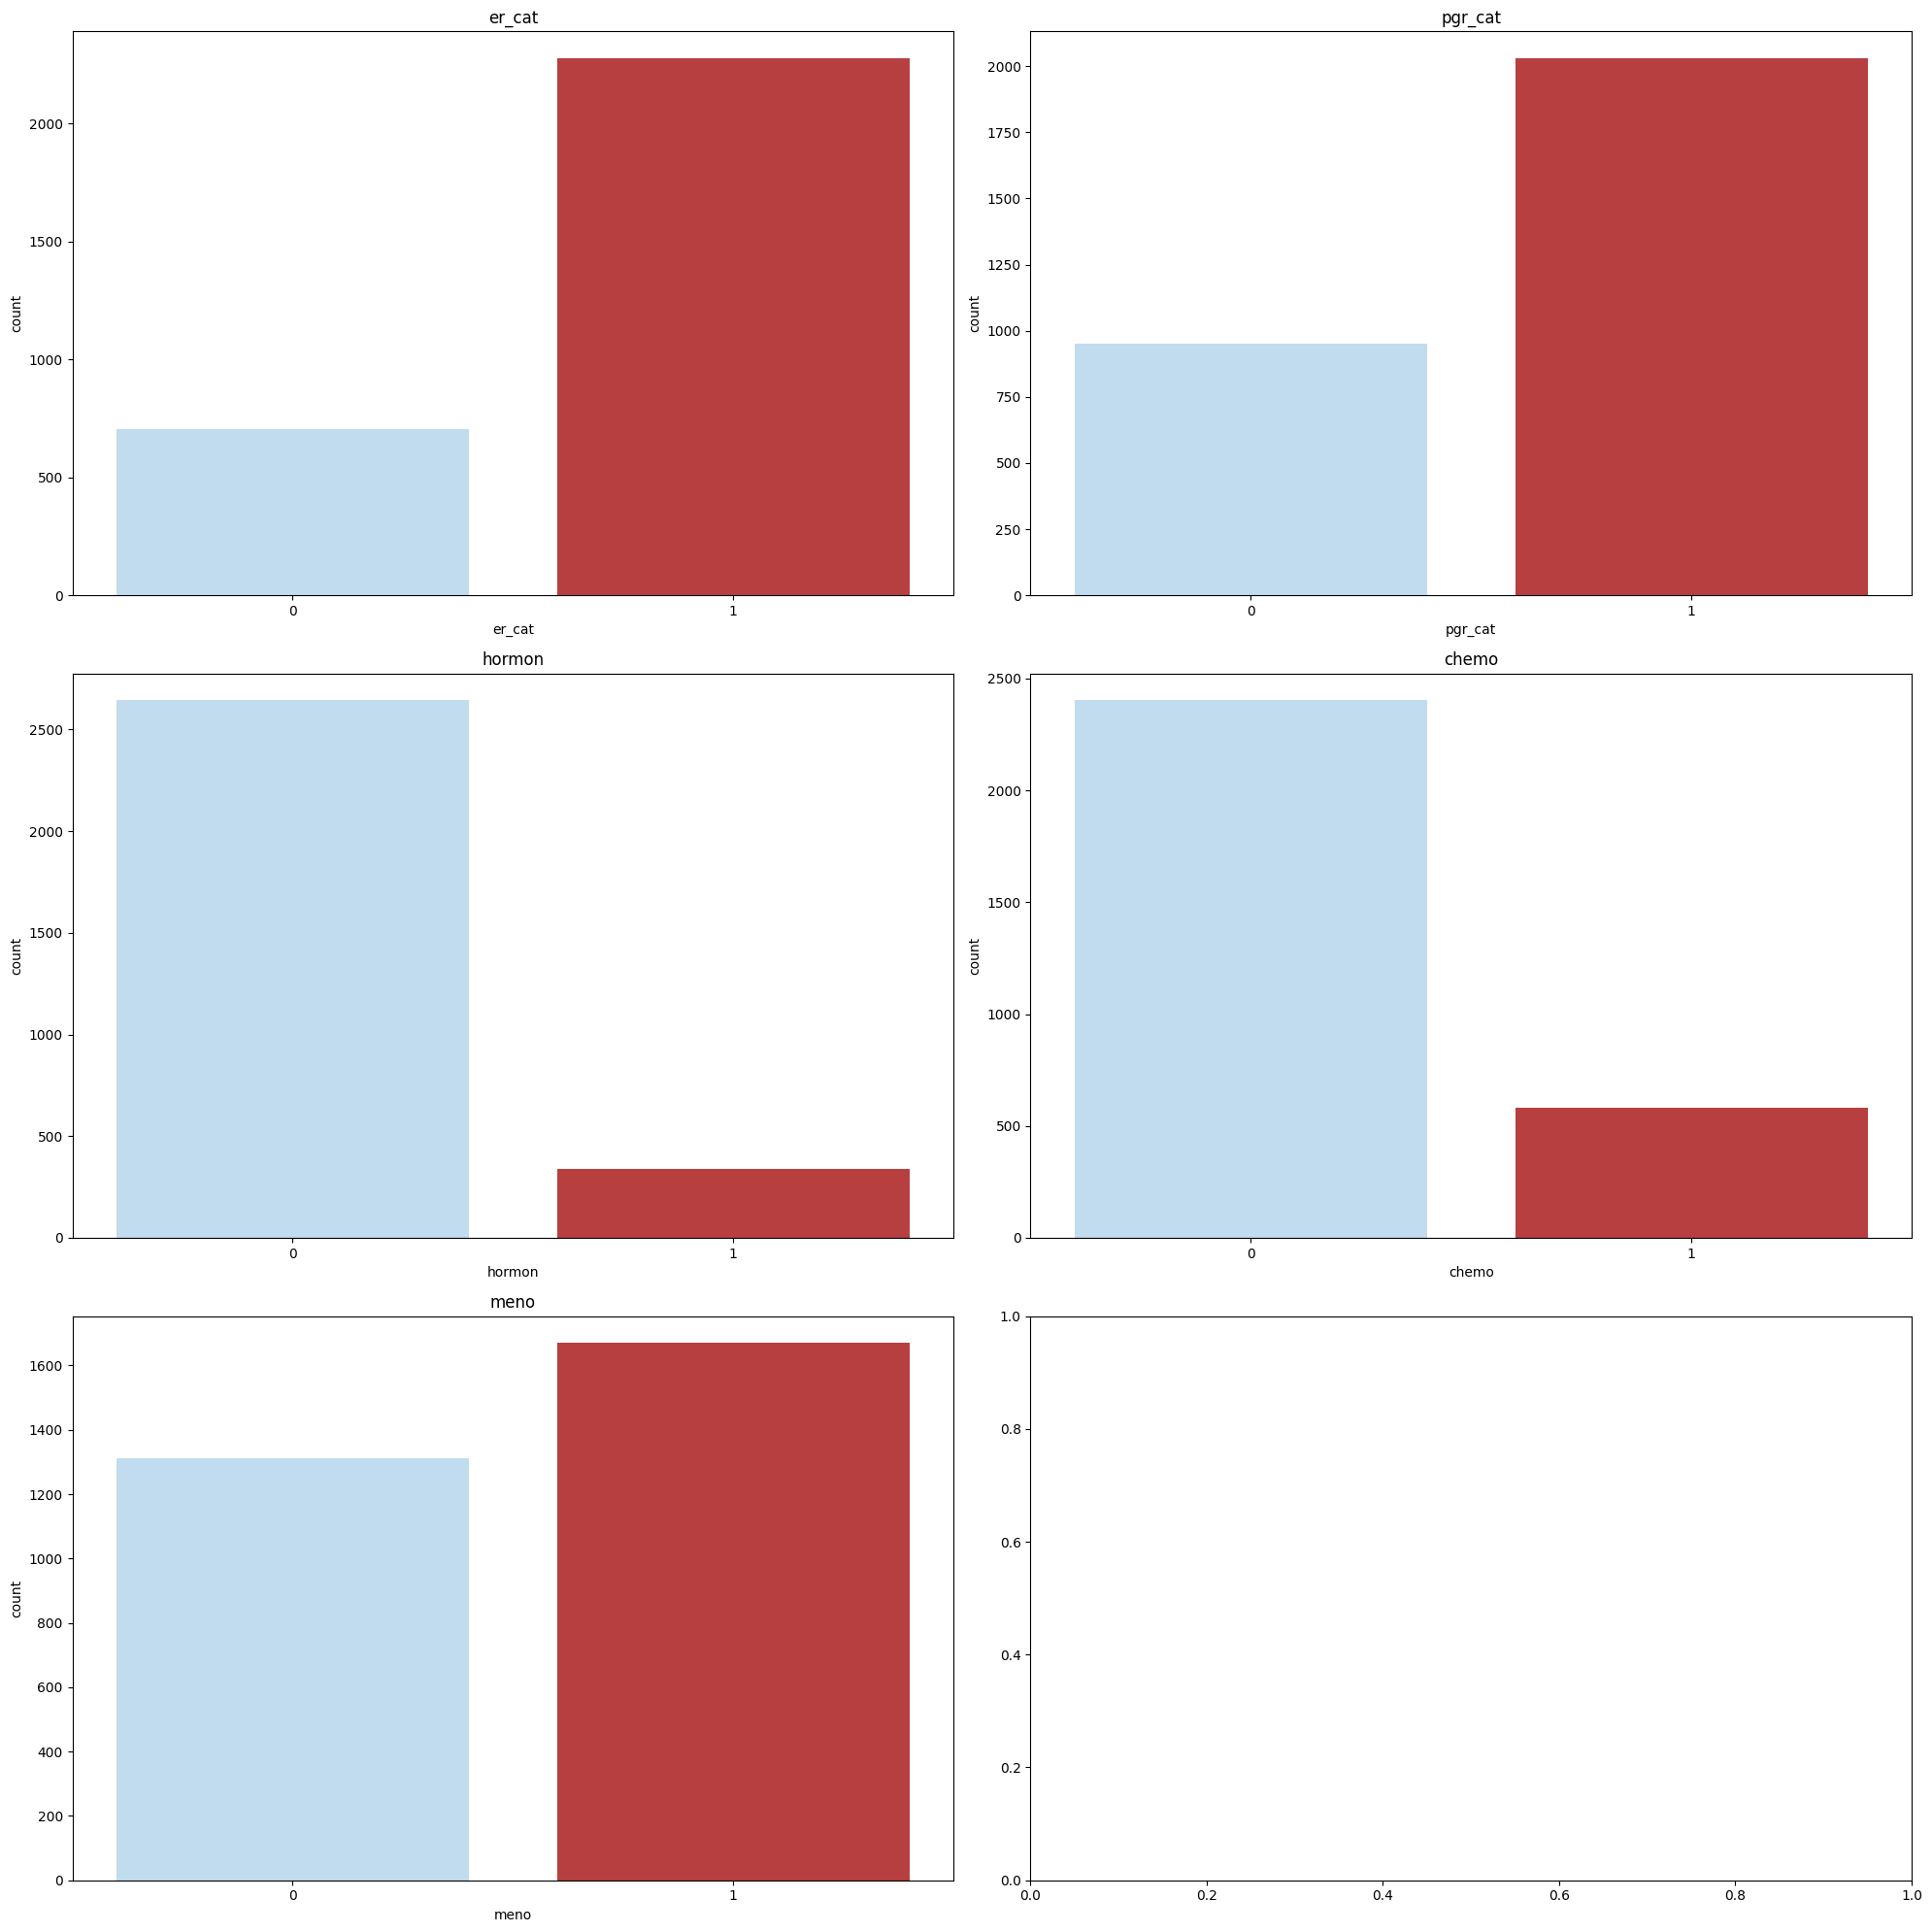

In [12]:
colors = ['#baddf5', '#cc2b2b']

fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (20,20))

ax = ax.flatten()
for i in range(len(cat_vars)):
    sns.countplot(data=df_clean, x=cat_vars[i], palette=colors, hue=cat_vars[i], legend=False, ax=ax[i])
    title = cat_vars[i]
    ax[i].set_title(title)
plt.tight_layout()
plt.show()

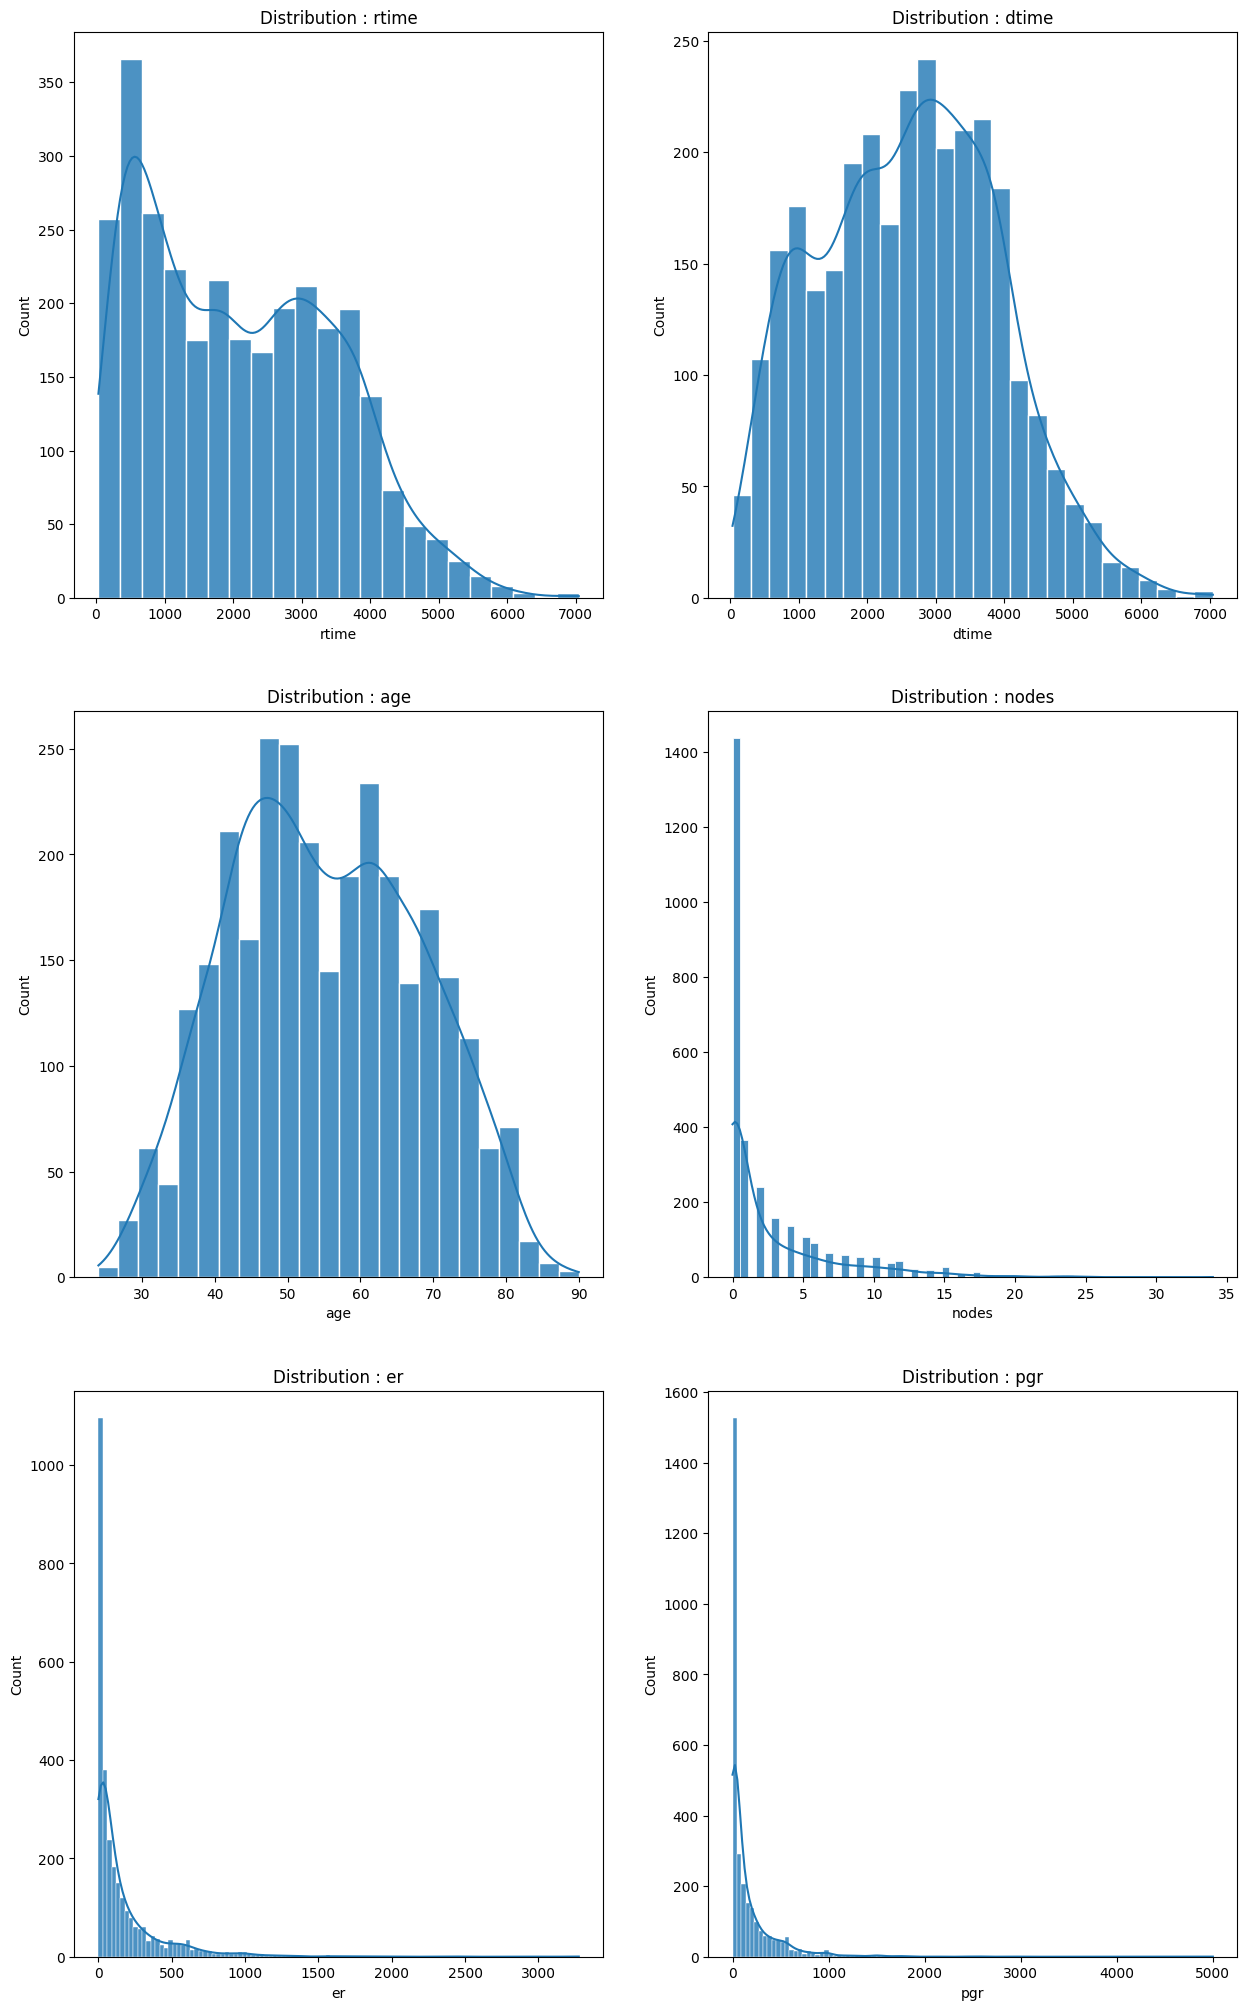

In [13]:
nrows = 3
ncols = 2

fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize = (15,25))
for i in range(len(num_vars)):
    plt.subplot(nrows, ncols, i+1)
    sns.histplot(
      data=df, x=num_vars[i], kde=True,
      alpha=.8, edgecolor=(1, 1, 1)
    )
    title = 'Distribution : ' + num_vars[i]
    plt.title(title)
plt.show()

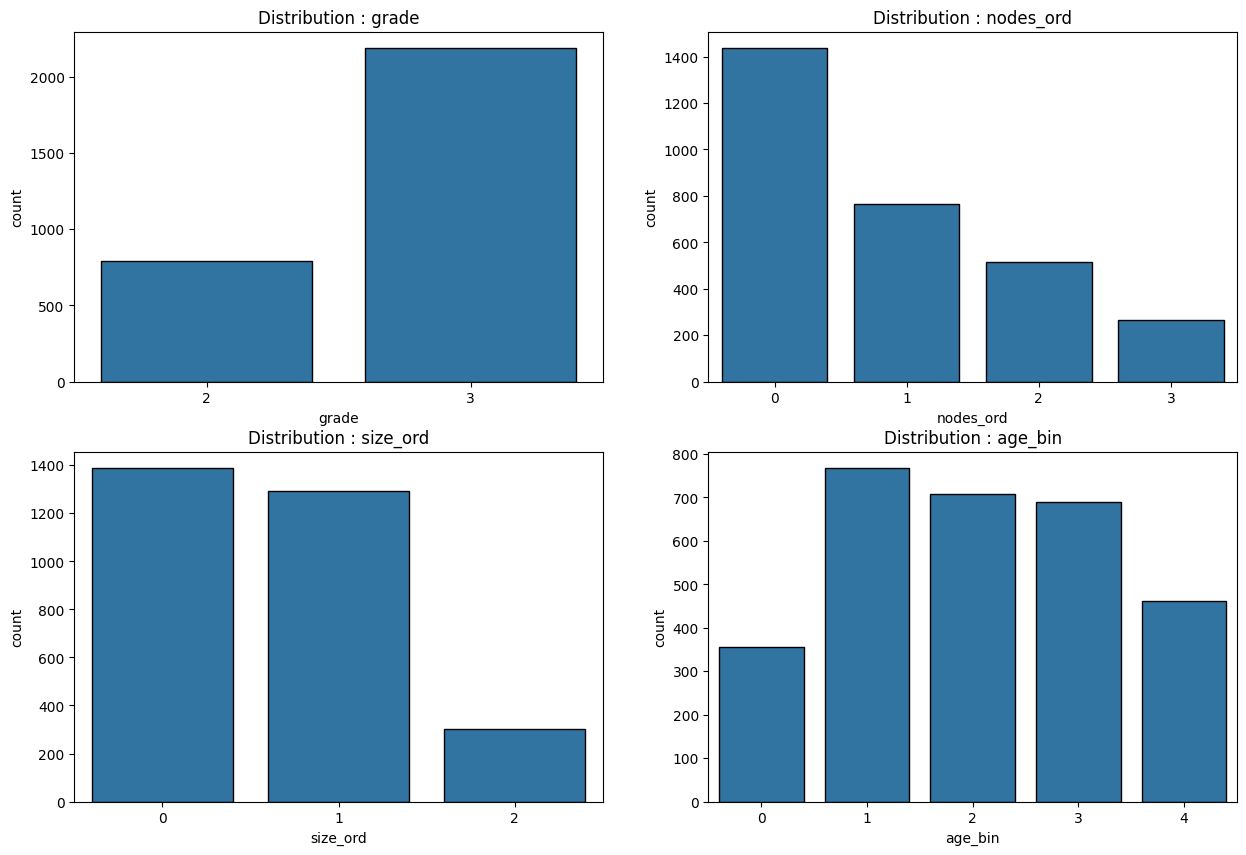

In [21]:
# plot the ordinal variables
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (15,10))
for i in range(len(ord_vars)):
    plt.subplot(2, 2, i+1)
    sns.countplot(data=df_clean, x=ord_vars[i], edgecolor=(0, 0, 0))
    title = 'Distribution : ' + ord_vars[i]
    plt.title(title)
plt.show()

In [22]:
import scipy.stats as stats
from scipy.stats import kurtosis, skew

results = []

for n in num_vars:
    k = kurtosis(df[n])
    s = skew(df[n])
    results.append({'variable': n, 'kurtosis': k, 'skewness': s})

ks_df = pd.DataFrame(results)

ks_df = ks_df.sort_values('kurtosis', ascending=False)
ks_df

,variable,kurtosis,skewness
5,pgr,40.42,4.57
4,er,24.42,3.83
3,nodes,7.17,2.38
1,dtime,-0.52,0.16
0,rtime,-0.73,0.42
2,age,-0.78,0.11


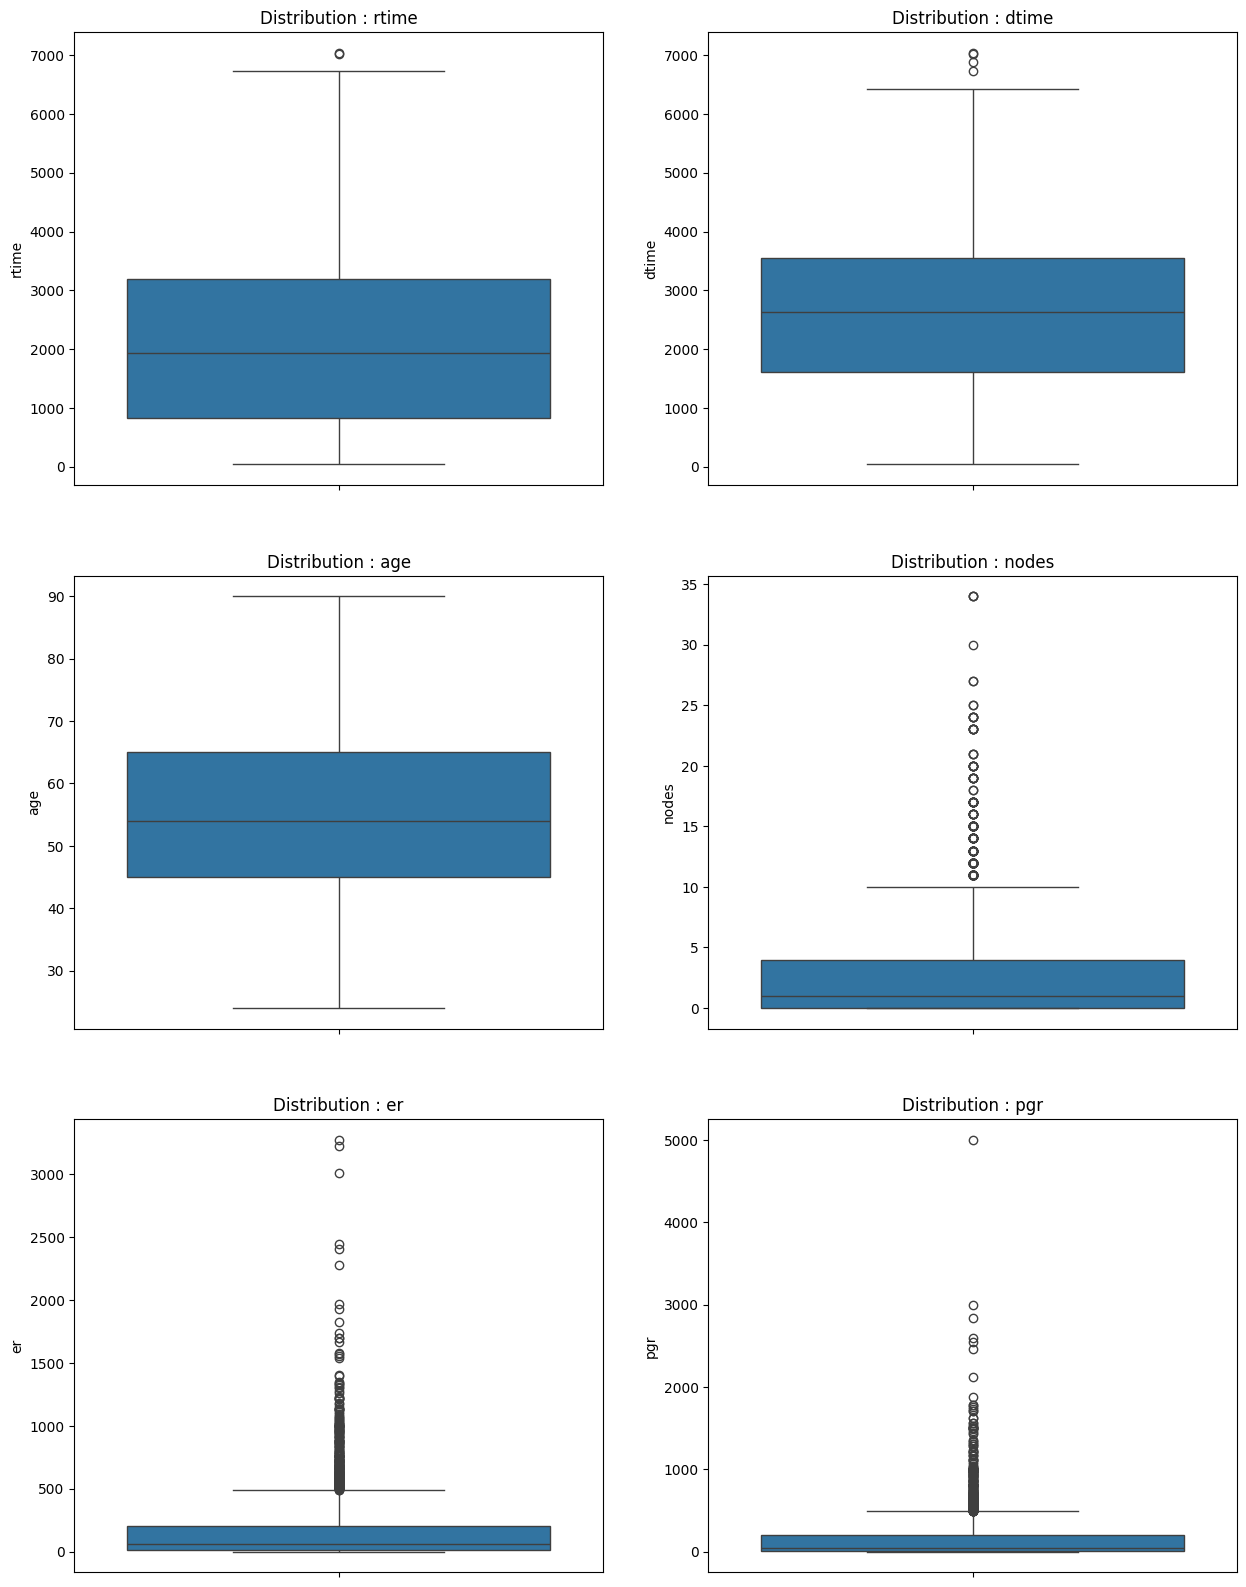

In [27]:
fig, ax = plt.subplots(nrows = 3,ncols = 2,figsize = (15,20))
for i in range(len(num_vars)):
    plt.subplot(3,2,i+1)
    sns.boxplot(data=df_clean, y=num_vars[i])
    title = 'Distribution : ' + num_vars[i]
    plt.title(title)
plt.show()

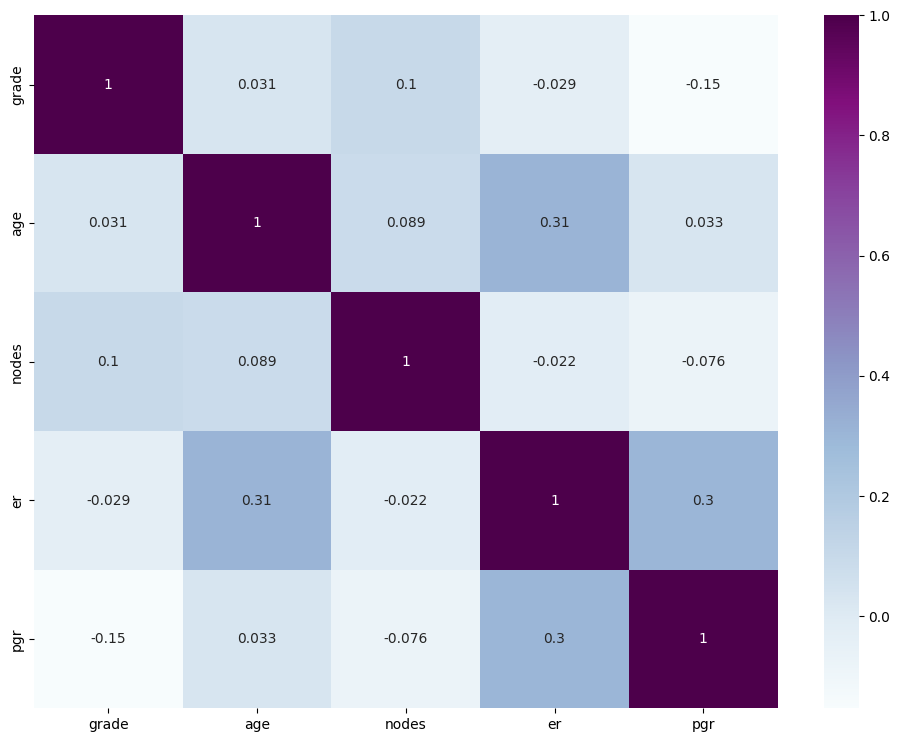

In [53]:
needed_corr = ['grade', 'age', 'nodes', 'er', 'pgr']
corrmat = df[needed_corr].corr()
plt.figure(figsize=(12,9))
sns.heatmap(corrmat, cmap="BuPu",annot=True);

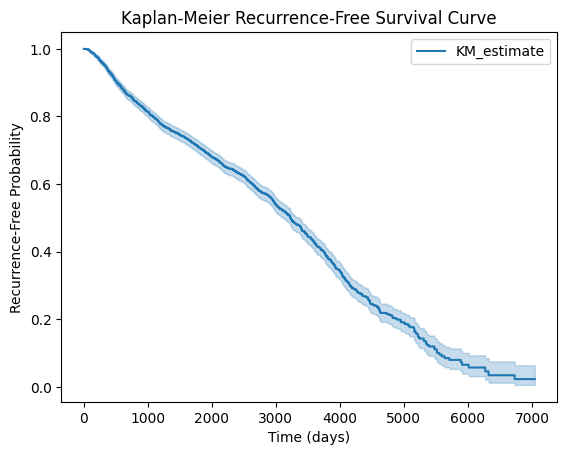

,KM_estimate
timeline,
0.00,1.00
36.00,1.00
38.00,1.00
45.00,1.00
49.00,1.00
...,...
6270.00,0.05
6323.00,0.03
6729.00,0.02


In [32]:
kmf = KaplanMeierFitter()
kmf.fit(durations = df_clean['rtime'], event_observed = df_clean['recur'])
kmf.plot(ci_show=True)
plt.xlabel('Time (days)')
plt.ylabel('Recurrence-Free Probability')
plt.title('Kaplan-Meier Recurrence-Free Survival Curve')
plt.show()

kmf.survival_function_